# Random Forest (Classificação) — Notebook enxuto

Este notebook demonstra **apenas Random Forest** para um problema multiclasse sintético.

**Parâmetros-chave (ajustáveis):**
- `class_sep`: separação entre as classes ao gerar o dataset sintético. Valores maiores tornam as classes mais separáveis.
- `n_estimators`: número de árvores na floresta. Mais árvores tendem a estabilizar a performance, com maior custo computacional.
- `max_depth`: profundidade máxima de cada árvore. Controla a complexidade e ajuda a evitar overfitting.
- `n_jobs`: número de *threads* para paralelizar o treinamento/predição (`-1` usa todos os núcleos disponíveis).

Inclui:
- geração de dados com **8 features** (4 informativas, 2 redundantes, 2 ruidosas) e **8 classes**;
- particionamento treino/teste e **padronização**;
- treino do `RandomForestClassifier` com parâmetros ajustáveis;
- **acurácia** no teste, **matriz de confusão** e **fronteiras de decisão 2D** para quatro pares de features:
  - (1,2), (3,4), (5,6), (7,8).


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# 1) Dados sintéticos (moderados para Colab gratuito)
class_sep = 1.5  # <-- ajuste aqui
X, y = make_classification(
    n_samples=10000,
    n_features=8,
    n_informative=4,
    n_redundant=2,
    n_repeated=0,
    n_classes=8,
    n_clusters_per_class=1,
    class_sep=class_sep,
    random_state=37
)

# 2) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=37, stratify=y
)

# 3) Padronização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
print('Shapes -> X_train:', X_train_scaled.shape, '| X_test:', X_test_scaled.shape)

Shapes -> X_train: (7000, 8) | X_test: (3000, 8)


Acurácia (teste) - Random Forest: 0.8660


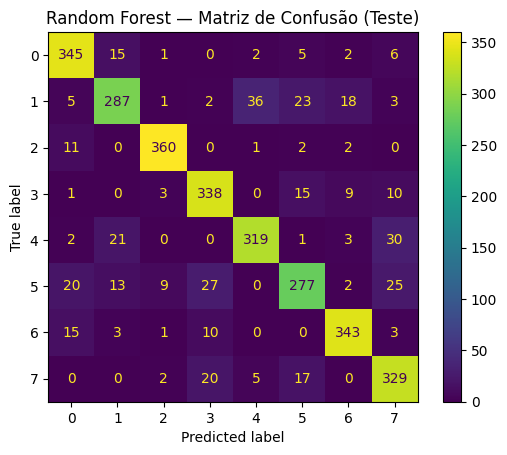

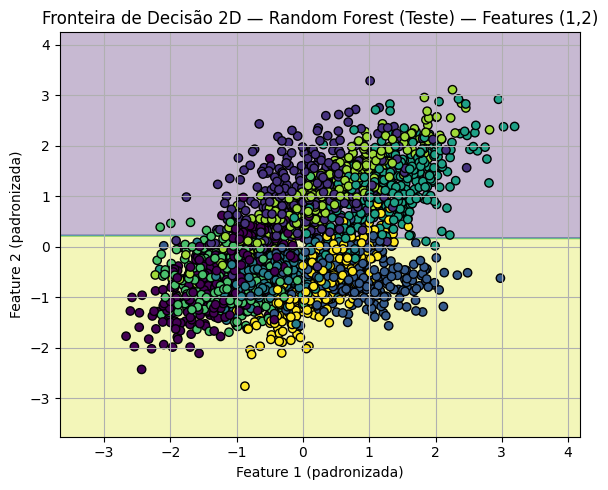

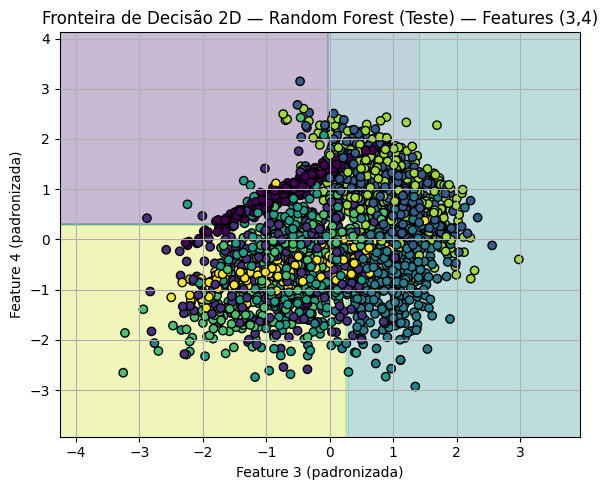

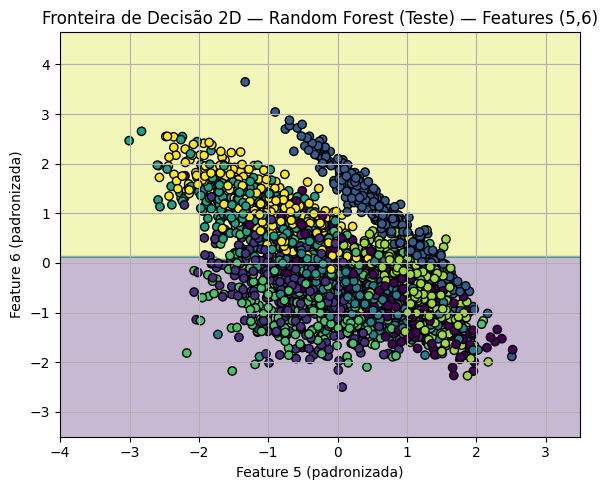

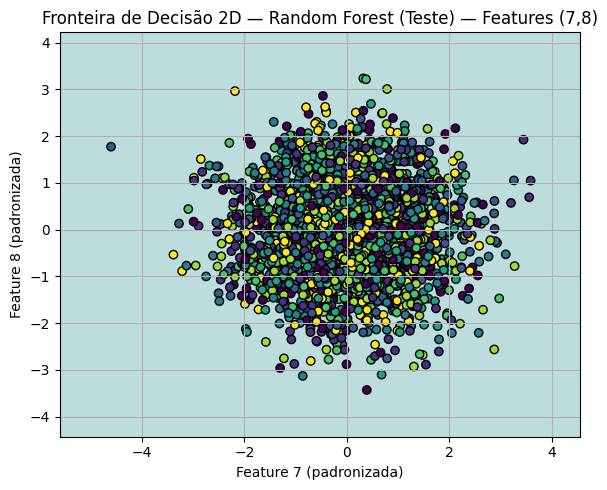

In [7]:
# 4) Random Forest (apenas RF) — parâmetros principais
n_estimators = 50   # número de árvores
max_depth    = 6    # profundidade máxima de cada árvore
n_jobs       = -1   # paralelismo (use -1 para todos os núcleos)
random_state = 42

rf = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    random_state=random_state,
    n_jobs=n_jobs
)
rf.fit(X_train_scaled, y_train)

# 5) Avaliação
rf_pred = rf.predict(X_test_scaled)
rf_acc = accuracy_score(y_test, rf_pred)
print(f'Acurácia (teste) - Random Forest: {rf_acc:.4f}')

# Matriz de confusão (sem escolher cmap explicitamente)
cm = confusion_matrix(y_test, rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='d')
plt.title('Random Forest — Matriz de Confusão (Teste)')
plt.show()

# 6) Fronteiras de decisão 2D para pares de features
# Para cada par (i, j), usamos somente essas duas dimensões padronizadas para visualização.
# Para o grid, expandimos ao espaço completo preenchendo as demais dimensões com zero.

def plot_decision_boundary_pair(model, X_scaled, y, feat_i, feat_j, title_prefix):
    h = 0.05
    X_vis = X_scaled[:, [feat_i, feat_j]]
    x_min, x_max = X_vis[:, 0].min() - 1.0, X_vis[:, 0].max() + 1.0
    y_min, y_max = X_vis[:, 1].min() - 1.0, X_vis[:, 1].max() + 1.0
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    X_grid2 = np.c_[xx.ravel(), yy.ravel()]

    # Expandir para todas as dimensões (demais = 0)
    X_full = np.zeros((X_grid2.shape[0], X_scaled.shape[1]))
    X_full[:, feat_i] = X_grid2[:, 0]
    X_full[:, feat_j] = X_grid2[:, 1]

    Z = model.predict(X_full).reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.3)   # sem definir cmap
    plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y, edgecolor='k')
    plt.xlabel(f'Feature {feat_i+1} (padronizada)')
    plt.ylabel(f'Feature {feat_j+1} (padronizada)')
    plt.title(f'{title_prefix} — Features ({feat_i+1},{feat_j+1})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Pares solicitados: (1,2), (3,4), (5,6), (7,8) -> em zero-based: (0,1), (2,3), (4,5), (6,7)
pairs = [(0,1), (2,3), (4,5), (6,7)]
for (i, j) in pairs:
    plot_decision_boundary_pair(rf, X_test_scaled, y_test, i, j, 'Fronteira de Decisão 2D — Random Forest (Teste)')